In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("plameneduardo/sarscov2-ctscan-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Usuario\.cache\kagglehub\datasets\plameneduardo\sarscov2-ctscan-dataset\versions\2


In [6]:
# Classificação de Tomografias Computadorizadas COVID-19 usando Deep Learning
# Dataset: SARS-CoV-2 CT Scan Dataset do Kaggle
# Objetivo: Classificação binária de tomografias (COVID-19 positivo vs negativo)

"""
INSTRUÇÕES DE CONFIGURAÇÃO:
1. Baixe o dataset de: https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset
2. Faça upload para o Google Colab ou monte o Google Drive
3. Atualize a variável DATA_PATH abaixo com a localização do seu dataset
"""

# ============================================================================
# PASSO 1: INSTALAR E IMPORTAR BIBLIOTECAS NECESSÁRIAS
# ============================================================================

# Instalar pacotes adicionais se necessário
# !pip install tensorflow opencv-python scikit-learn matplotlib seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
import cv2
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Definir sementes aleatórias para reprodutibilidade
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [7]:
# ============================================================================
# PASSO 2: CONFIGURAR CAMINHO DO DATASET E PARÂMETROS
# ============================================================================

# ATUALIZE ESTE CAMINHO de acordo com onde você fez upload do dataset
DATA_PATH = path
# Alternativa: DATA_PATH = '/content/SARS-CoV-2-CT-Scan'

# Parâmetros das imagens
IMG_HEIGHT = 224  # Tamanho padrão para modelos de transfer learning
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50  # Usaremos early stopping

# Nomes das classes
CLASS_NAMES = ['COVID', 'non-COVID']

In [8]:
# ============================================================================
# PASSO 3: CARREGAMENTO E EXPLORAÇÃO DOS DADOS
# ============================================================================

"""
Estrutura esperada do dataset:
COVID_Dataset/
  ├── COVID/
  │   ├── image1.png
  │   ├── image2.png
  │   └── ...
  └── non-COVID/
      ├── image1.png
      ├── image2.png
      └── ...
"""

# Contar imagens em cada classe
covid_path = os.path.join(DATA_PATH, 'COVID')
non_covid_path = os.path.join(DATA_PATH, 'non-COVID')

# Verificar se os caminhos existem (descomente ao executar)
covid_count = len(os.listdir(covid_path)) if os.path.exists(covid_path) else 0
non_covid_count = len(os.listdir(non_covid_path)) if os.path.exists(non_covid_path) else 0

# Imprimir estatísticas do dataset
print(f"Total de tomografias COVID-19 positivas: {covid_count}")
print(f"Total de tomografias não-COVID: {non_covid_count}")
print(f"Total de imagens: {covid_count + non_covid_count}")
print(f"Balanceamento do dataset: {covid_count/(covid_count + non_covid_count)*100:.2f}% COVID positivo")

Total de tomografias COVID-19 positivas: 1252
Total de tomografias não-COVID: 1229
Total de imagens: 2481
Balanceamento do dataset: 50.46% COVID positivo


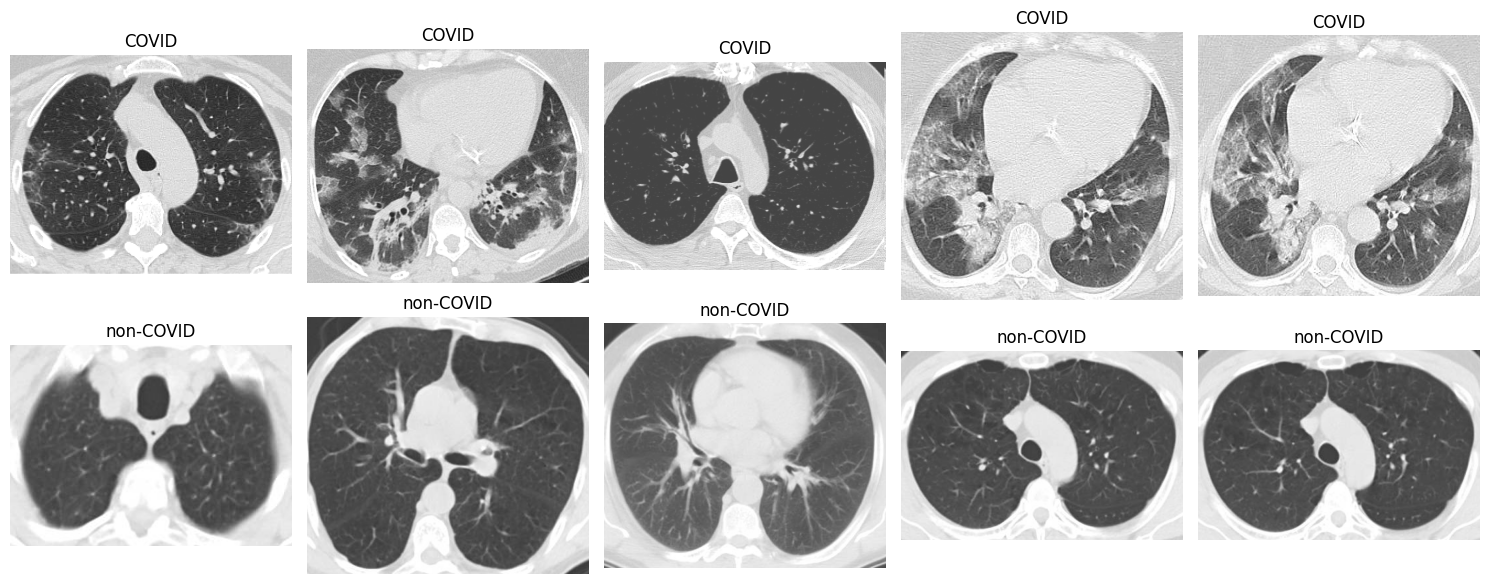

In [9]:
# ============================================================================
# PASSO 4: VISUALIZAÇÃO DOS DADOS
# ============================================================================

def plot_sample_images(data_path, class_names, n_samples=5):
    """
    Exibir imagens de amostra de cada classe para inspeção visual
    Isso ajuda a verificar a qualidade dos dados e entender as características visuais
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        images = os.listdir(class_path)[:n_samples]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(class_name)

    plt.tight_layout()
    plt.show()

# Descomente para visualizar amostras
plot_sample_images(DATA_PATH, CLASS_NAMES)

In [10]:
# ============================================================================
# PASSO 5: PRÉ-PROCESSAMENTO E AUMENTO DE DADOS
# ============================================================================

"""
O aumento de dados (data augmentation) é crucial para:
- Prevenir overfitting
- Melhorar a generalização do modelo
- Simular diferentes condições de escaneamento
"""

# Aumento de dados para treinamento
# Inclui rotações, deslocamentos e espelhamentos para simular variações nas tomografias
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalizar valores de pixel para [0,1]
    validation_split=0.2,        # Usar 20% para validação
    rotation_range=15,           # Rotações aleatórias até 15 graus
    width_shift_range=0.1,       # Deslocamentos horizontais
    height_shift_range=0.1,      # Deslocamentos verticais
    horizontal_flip=True,        # Espelhamentos horizontais aleatórios
    zoom_range=0.1,              # Zoom aleatório
    fill_mode='nearest'          # Estratégia de preenchimento para augmentation
)

# Dados de validação/teste - apenas reescalonamento (sem augmentation)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Gerar dados de treinamento
train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',         # Classificação binária
    subset='training',
    shuffle=True,
    seed=42
)

# Gerar dados de validação
validation_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

# Imprimir mapeamento dos índices de classe
print("Índices das classes:", train_generator.class_indices)

Found 1986 images belonging to 2 classes.
Found 495 images belonging to 2 classes.
Índices das classes: {'COVID': 0, 'non-COVID': 1}


In [11]:
# ============================================================================
# PASSO 6: ARQUITETURA DO MODELO - CNN COM TRANSFER LEARNING
# ============================================================================

"""
Usando MobileNetV2 como modelo base:
- Pré-treinado no ImageNet
- Eficiente e leve
- Bom desempenho em imagens médicas
- Treinamento e inferência rápidos
"""

def build_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    """
    Construir uma Rede Neural Convolucional usando transfer learning
    Arquitetura: MobileNetV2 (pré-treinado) + Classificador customizado
    """

    # Carregar MobileNetV2 pré-treinado sem as camadas superiores
    base_model = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,          # Excluir classificador do ImageNet
        weights='imagenet'           # Usar pesos pré-treinados do ImageNet
    )

    # Congelar camadas do modelo base (transfer learning)
    # Isso preserva as features aprendidas do ImageNet
    base_model.trainable = False

    # Construir classificador customizado no topo
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),    # Reduzir dimensões espaciais
        layers.Dropout(0.5),                 # Prevenir overfitting
        layers.Dense(128, activation='relu'), # Camada de extração de features
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid') # Saída binária (COVID vs não-COVID)
    ])

    return model

# Criar instância do modelo
model = build_model()

# Exibir arquitetura do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# ============================================================================
# PASSO 7: COMPILAÇÃO DO MODELO
# ============================================================================

"""
Configuração para treinamento:
- Otimizador: Adam (taxa de aprendizado adaptativa)
- Loss: Binary crossentropy (para classificação binária)
- Métricas: Acurácia, Precisão, Recall para avaliação abrangente
"""

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

In [13]:
# ============================================================================
# PASSO 8: CALLBACKS PARA OTIMIZAÇÃO DO TREINAMENTO
# ============================================================================

"""
Callbacks melhoram a eficiência do treinamento:
- EarlyStopping: Previne overfitting parando quando a loss de validação para de melhorar
- ReduceLROnPlateau: Reduz taxa de aprendizado quando o treinamento estagna
"""

# Parar treinamento se a loss de validação não melhorar por 10 épocas
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduzir taxa de aprendizado se a loss de validação estagnar
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,              # Reduzir LR pela metade
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

In [14]:
# ============================================================================
# PASSO 9: TREINAMENTO DO MODELO
# ============================================================================

"""
Treinando o modelo com dados de tomografias COVID-19
Monitorar métricas de treinamento e validação para detectar overfitting
"""

# Calcular passos por época
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Treinar o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.7073 - loss: 0.6221 - precision: 0.7042 - recall: 0.7042 - val_accuracy: 0.7500 - val_loss: 0.4991 - val_precision: 0.7183 - val_recall: 0.7870 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - accuracy: 0.8438 - loss: 0.4257 - precision: 1.0000 - recall: 0.7059 - val_accuracy: 0.7437 - val_loss: 0.4944 - val_precision: 0.7082 - val_recall: 0.7913 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.7810 - loss: 0.4603 - precision: 0.7704 - recall: 0.7973 - val_accuracy: 0.7312 - val_loss: 0.5139 - val_precision: 0.6689 - val_recall: 0.8696 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 298ms/step - accuracy: 0.7500 - loss: 0.5842 - precision: 0.6429 - recall: 0.7500 - val_accuracy: 0.7375 - val_loss: 0.5148 - val_precision: 0.6912 - val_recall: 0.8174 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8

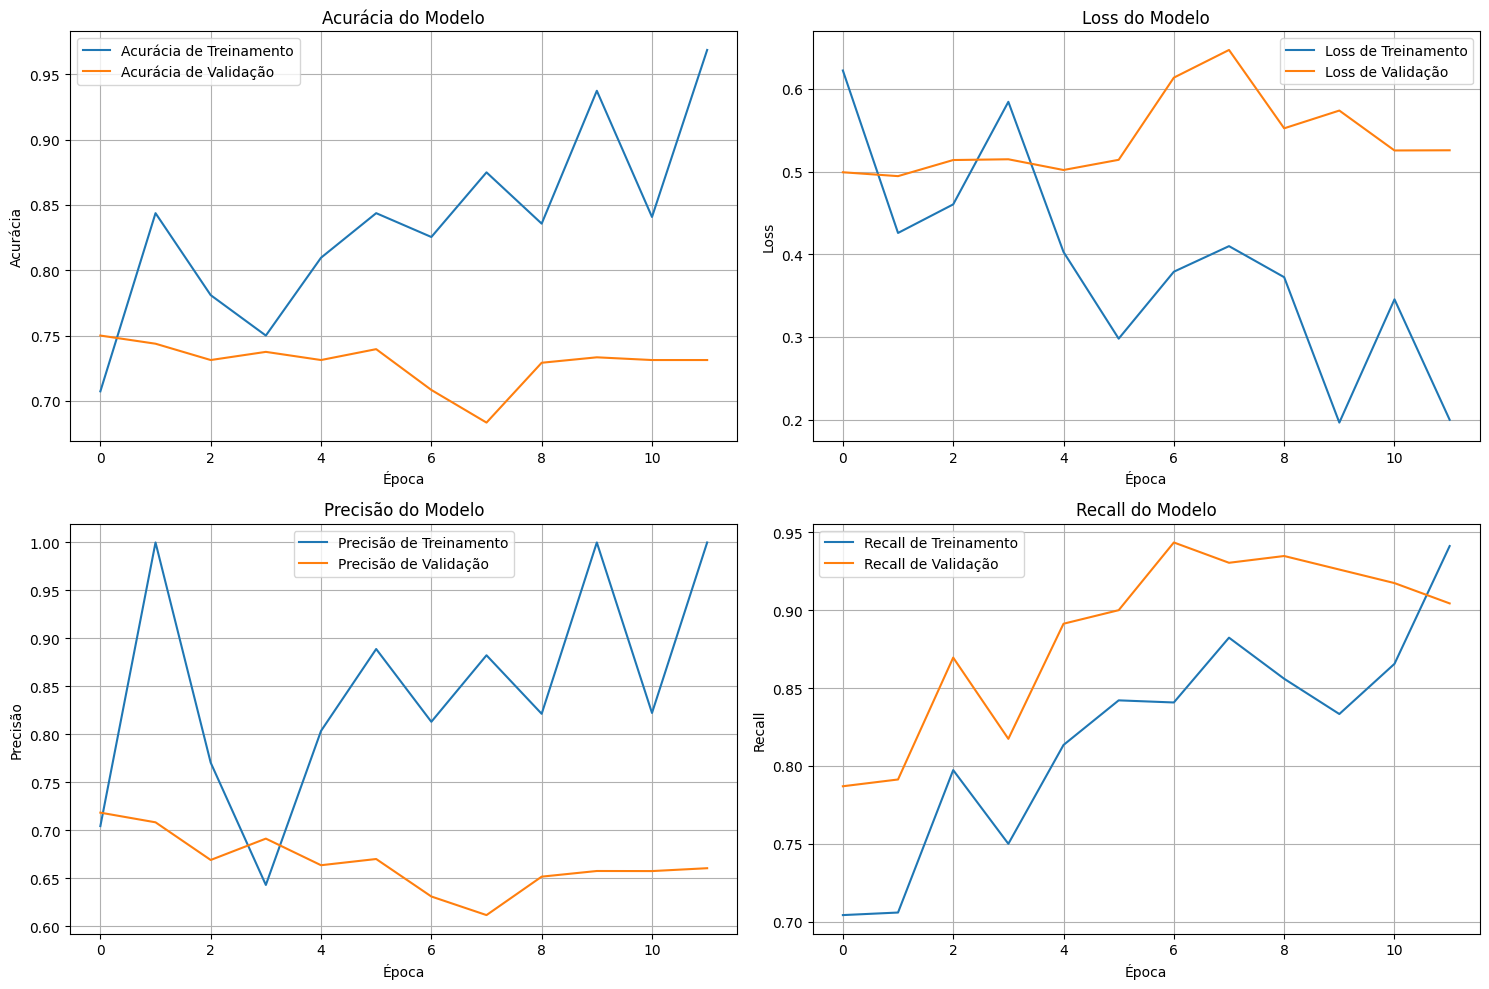

In [15]:
# ============================================================================
# PASSO 10: VISUALIZAÇÃO DO HISTÓRICO DE TREINAMENTO
# ============================================================================

"""
Visualizar o progresso do treinamento para identificar:
- Padrões de convergência
- Indicadores de overfitting
- Estabilidade do modelo
"""

def plot_training_history(history):
    """Plotar métricas de treinamento e validação ao longo das épocas"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Gráfico de Acurácia
    axes[0, 0].plot(history.history['accuracy'], label='Acurácia de Treinamento')
    axes[0, 0].plot(history.history['val_accuracy'], label='Acurácia de Validação')
    axes[0, 0].set_title('Acurácia do Modelo')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Acurácia')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Gráfico de Loss
    axes[0, 1].plot(history.history['loss'], label='Loss de Treinamento')
    axes[0, 1].plot(history.history['val_loss'], label='Loss de Validação')
    axes[0, 1].set_title('Loss do Modelo')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Gráfico de Precisão
    axes[1, 0].plot(history.history['precision'], label='Precisão de Treinamento')
    axes[1, 0].plot(history.history['val_precision'], label='Precisão de Validação')
    axes[1, 0].set_title('Precisão do Modelo')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Precisão')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Gráfico de Recall
    axes[1, 1].plot(history.history['recall'], label='Recall de Treinamento')
    axes[1, 1].plot(history.history['val_recall'], label='Recall de Validação')
    axes[1, 1].set_title('Recall do Modelo')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plotar resultados do treinamento
plot_training_history(history)

In [16]:
# ============================================================================
# PASSO 11: AVALIAÇÃO DO MODELO NO CONJUNTO DE VALIDAÇÃO
# ============================================================================

"""
Avaliação abrangente usando múltiplas métricas:
- Acurácia: Correção geral
- Precisão: Proporção de previsões positivas corretas
- Recall (Sensibilidade): Capacidade de encontrar todos os casos positivos
- F1-Score: Média harmônica entre precisão e recall
"""

# Gerar previsões no conjunto de validação
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_steps, verbose=1)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = validation_generator.classes[:len(y_pred)]

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Exibir resultados
print("\n" + "="*60)
print("RESULTADOS DA AVALIAÇÃO DO MODELO")
print("="*60)
print(f"Acurácia:  {accuracy*100:.2f}%")
print(f"Precisão:  {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-Score:  {f1*100:.2f}%")
print("="*60)

# Relatório de classificação detalhado
print("\nRelatório de Classificação Detalhado:")
print(classification_report(y_true, y_pred, target_names=['não-COVID', 'COVID']))

15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step

RESULTADOS DA AVALIAÇÃO DO MODELO
Acurácia:  76.88%
Precisão:  72.62%
Recall:    83.04%
F1-Score:  77.48%

Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

   não-COVID       0.82      0.71      0.76       250
       COVID       0.73      0.83      0.77       230

    accuracy                           0.77       480
   macro avg       0.77      0.77      0.77       480
weighted avg       0.78      0.77      0.77       480



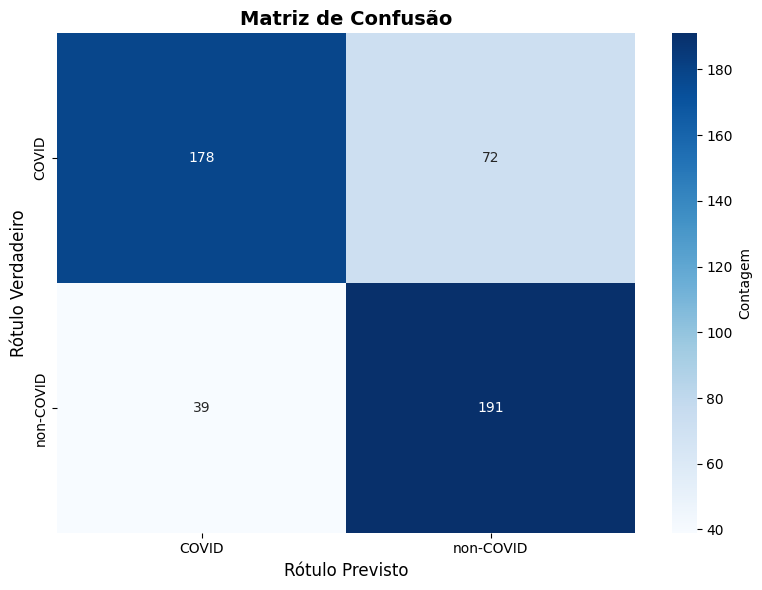


Detalhamento da Matriz de Confusão:
Verdadeiros Negativos (VN):  178 - Não-COVID identificados corretamente
Falsos Positivos (FP):       72 - Não-COVID classificados incorretamente como COVID
Falsos Negativos (FN):       39 - COVID classificados incorretamente como não-COVID (Crítico!)
Verdadeiros Positivos (VP):  191 - COVID identificados corretamente

Especificidade: 71.20% (capacidade de identificar não-COVID)


In [17]:
# ============================================================================
# PASSO 12: VISUALIZAÇÃO DA MATRIZ DE CONFUSÃO
# ============================================================================

"""
A matriz de confusão mostra:
- Verdadeiros Positivos (VP): Casos COVID identificados corretamente
- Verdadeiros Negativos (VN): Casos não-COVID identificados corretamente
- Falsos Positivos (FP): Não-COVID classificados como COVID (Erro Tipo I)
- Falsos Negativos (FN): COVID classificados como não-COVID (Erro Tipo II - mais crítico!)
"""

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Visualizar matriz de confusão com anotações"""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Contagem'})
    plt.title('Matriz de Confusão', fontsize=14, fontweight='bold')
    plt.ylabel('Rótulo Verdadeiro', fontsize=12)
    plt.xlabel('Rótulo Previsto', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Imprimir interpretação da matriz de confusão
    tn, fp, fn, tp = cm.ravel()
    print(f"\nDetalhamento da Matriz de Confusão:")
    print(f"Verdadeiros Negativos (VN):  {tn} - Não-COVID identificados corretamente")
    print(f"Falsos Positivos (FP):       {fp} - Não-COVID classificados incorretamente como COVID")
    print(f"Falsos Negativos (FN):       {fn} - COVID classificados incorretamente como não-COVID (Crítico!)")
    print(f"Verdadeiros Positivos (VP):  {tp} - COVID identificados corretamente")

    # Significância clínica
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"\nEspecificidade: {specificity*100:.2f}% (capacidade de identificar não-COVID)")

plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)

In [18]:
# ============================================================================
# PASSO 13: SALVAR O MODELO TREINADO
# ============================================================================

"""
Salvar modelo para uso futuro:
- Implantação em sistemas clínicos
- Ajuste fino adicional
- Transfer learning para tarefas relacionadas
"""

# Salvar modelo no formato nativo do Keras
model.save('covid_ct_classifier.keras')
print("\nModelo salvo como 'covid_ct_classifier.keras'")

# Alternativa: Salvar no formato TensorFlow SavedModel
# model.save('covid_ct_model', save_format='tf')


Modelo salvo como 'covid_ct_classifier.keras'


In [19]:
# ============================================================================
# PASSO 14: FUNÇÃO DE PREVISÃO PARA NOVAS TOMOGRAFIAS
# ============================================================================

"""
Função para classificar novas imagens de tomografia
Pode ser usada para implantação ou teste em novos dados
"""

def predict_ct_scan(image_path, model, threshold=0.5):
    """
    Prever presença de COVID-19 em uma imagem de tomografia

    Args:
        image_path: Caminho para a imagem da tomografia
        model: Modelo Keras treinado
        threshold: Limiar de classificação (padrão 0.5)

    Returns:
        prediction: Rótulo da classe ('COVID' ou 'não-COVID')
        confidence: Confiança da previsão (0-100%)
    """

    # Carregar e pré-processar imagem
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img_array = img / 255.0  # Normalizar
    img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão de batch

    # Fazer previsão
    prediction_prob = model.predict(img_array, verbose=0)[0][0]
    prediction_class = 'COVID' if prediction_prob > threshold else 'não-COVID'
    confidence = prediction_prob * 100 if prediction_prob > threshold else (1 - prediction_prob) * 100

    # Visualizar resultado
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Previsão: {prediction_class} (Confiança: {confidence:.2f}%)',
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return prediction_class, confidence

# Exemplo de uso (descomente quando tiver uma imagem de teste):
# test_image_path = '/caminho/para/imagem/teste.png'
# pred_class, conf = predict_ct_scan(test_image_path, model)
# print(f"Previsto: {pred_class} com {conf:.2f}% de confiança")

In [20]:
# ============================================================================
# NOTAS PARA O ARTIGO CIENTÍFICO
# ============================================================================

"""
PONTOS-CHAVE PARA INCLUIR NO SEU ARTIGO:

1. INTRODUÇÃO:
   - Impacto da pandemia de COVID-19
   - Importância do diagnóstico automatizado
   - Tomografias computadorizadas como ferramenta diagnóstica
   - Inteligência Artificial em imagens médicas

2. METODOLOGIA:
   - Descrição do dataset (2.482 tomografias de São Paulo, Brasil)
   - Etapas de pré-processamento (normalização, redimensionamento para 224x224)
   - Técnicas de aumento de dados
   - Arquitetura do modelo (MobileNetV2 + classificador customizado)
   - Abordagem de transfer learning
   - Parâmetros de treinamento (batch size, épocas, otimizador)

3. RESULTADOS:
   - Reportar acurácia, precisão, recall e F1-score
   - Incluir matriz de confusão
   - Comparar com baseline (xDNN: 97.31% F1)
   - Curvas de treinamento mostrando convergência
   - Métricas de eficiência computacional

4. DISCUSSÃO:
   - Significância clínica dos resultados
   - Impacto de falsos positivos vs falsos negativos
   - Limitações do modelo
   - Questões de generalização
   - Comparação com outros métodos

5. CONCLUSÃO:
   - Resumo dos achados
   - Trabalhos futuros (datasets maiores, classificação multi-classe, explicabilidade)
   - Potenciais aplicações clínicas

CONSIDERAÇÕES ÉTICAS:
- Privacidade e anonimização dos dados
- Modelo como apoio à decisão (não substituição de radiologistas)
- Necessidade de aprovação regulatória antes do uso clínico
- Viés nos dados de treinamento
"""

print("\n" + "="*60)
print("EXECUÇÃO DO NOTEBOOK CONCLUÍDA")
print("="*60)
print("\nPróximos passos:")
print("1. Revisar todas as métricas e visualizações")
print("2. Experimentar com hiperparâmetros")
print("3. Testar em dados adicionais se disponível")
print("4. Documentar descobertas para seu artigo científico")
print("="*60)


EXECUÇÃO DO NOTEBOOK CONCLUÍDA

Próximos passos:
1. Revisar todas as métricas e visualizações
2. Experimentar com hiperparâmetros
3. Testar em dados adicionais se disponível
4. Documentar descobertas para seu artigo científico
